### Look at Tallo and BAAD for species in FATES-MRV projects

#### Libraries 

In [1]:
import numpy as np
import xarray as xr
import csv
import pandas as pd

import functions_py.fates_xarray_functions as fa

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib import cm

import math as m
from scipy.optimize import curve_fit
from scipy.stats import linregress

### Read in Tallo and BAAD data

In [2]:
# Note these dataframes were processed in the notebook  v2_Tallo_analysis_global.ipynb
df_tallo = pd.read_csv('/pscratch/sd/j/jneedham/trait_data/df_tallo.csv')
df_baad = pd.read_csv('/pscratch/sd/j/jneedham/trait_data/df_baad.csv')


In [3]:
print(df_tallo.head(3))
#  remove rows with NA for species
df_tallo = df_tallo.dropna(subset=['species'])

            species  latitude  longitude   dbh  height height_outlier  \
0  Betula pubescens    67.395     28.723  10.0     5.6              N   
1       Picea abies    67.395     28.723  10.0     6.6              N   
2       Picea abies    67.395     28.723  10.0     8.5              N   

   crown_radius_m crown_radius_outlier                       PFT_tallo  \
0            1.65                    N             broadleaf_extratrop   
1            0.85                    N  needleleaf_evergreen_extratrop   
2            0.75                    N  needleleaf_evergreen_extratrop   

   crown_area  
0    8.552986  
1    2.269801  
2    1.767146  


### USA

#### Hybrid Populus tremula × Populus alba

In [4]:
# find the two 'parent' species
populus_alba = df_tallo[df_tallo['species'].str.contains('Populus alba', case=False)]
populus_tremula = df_tallo[df_tallo['species'].str.contains('Populus tremula', case=False)]

populus = pd.concat([populus_alba, populus_tremula], axis=0)

In [5]:
def d2hmc (d, p1, p2, p3) :
    h = (p1 * d**p2) / (p3 + d**p2)
    return h

initial_guess = [58.0, 0.73, 21.8]


In [6]:
pop_h =  populus.dropna(subset=['height', 'dbh'])
# remove outliers
pop_h = pop_h[pop_h['height_outlier'] == 'N']
pop_h = pop_h[pop_h['dbh'] < 100]
dbh_pop_h = np.arange(1,pop_h['dbh'].max(),1)

height_ps_pop, height_cov_pop = curve_fit(f=d2hmc, xdata=np.array(pop_h['dbh']), ydata=np.array(pop_h['height']),
                                           p0=initial_guess)
pop_curve_h = [d2hmc(d, height_ps_pop[0], height_ps_pop[1], height_ps_pop[2])  for  d  in dbh_pop_h]

palba_h = pop_h[pop_h['species']  ==  'Populus alba']
ptrem_h = pop_h[pop_h['species']  ==  'Populus tremula']

print(height_ps_pop)

[30.84653668  1.10525761 18.05775934]


In [7]:
def d2ca (d, p1) :
    ca = d ** p1
    return ca

In [8]:
pop_ca = populus.dropna(subset=['crown_area','dbh'])
# remove outliers
pop_ca = pop_ca[pop_ca['crown_radius_outlier'] == 'N']
pop_ca = pop_ca[pop_ca['dbh'] < 100]
dbh_pop_ca = np.arange(1,pop_ca['dbh'].max(),1)

ca_ps_pop, ca_cov_pop = curve_fit(f=d2ca, xdata=np.array(pop_ca['dbh']), ydata=np.array(pop_ca['crown_area']), p0=1.3)

pop_curve_ca = [d2ca(d, ca_ps_pop[0])  for  d  in dbh_pop_ca]
palba_ca = pop_ca[pop_ca['species']  ==  'Populus alba']
ptrem_ca = pop_ca[pop_ca['species']  ==  'Populus tremula']

print(ca_ps_pop)

[1.00515389]


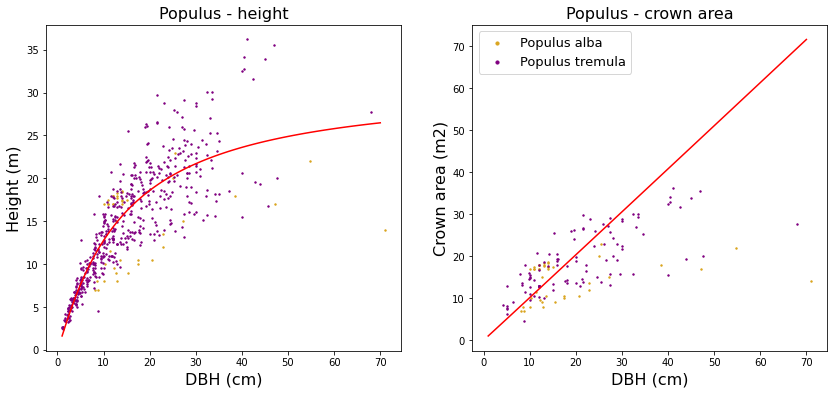

In [9]:
fig, ((fax0,fax1)) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

fax0.scatter(palba_h.dbh, palba_h.height, c='goldenrod', s=2, label = 'Populus alba')
fax0.scatter(ptrem_h.dbh, ptrem_h.height, c='purple', s=2, label = 'Populus tremula')
fax0.plot(dbh_pop_h, pop_curve_h, color='red')
fax0.set_title('Populus - height', fontsize=16)
fax0.set_ylabel('Height (m)', fontsize=16)
fax0.set_xlabel('DBH (cm)', fontsize=16)

    
fax1.scatter(palba_ca.dbh, palba_ca.height, c='goldenrod', s=2, label = 'Populus alba')
fax1.scatter(ptrem_ca.dbh, ptrem_ca.height, c='purple', s=2, label = 'Populus tremula')
fax1.plot(dbh_pop_ca, pop_curve_ca, color='red')
fax1.set_title('Populus - crown area', fontsize=16)
fax1.set_ylabel('Crown area (m2)', fontsize=16)
fax1.set_xlabel('DBH (cm)', fontsize=16)
fax1.legend(fontsize=13)    

# Get the legend object
legend = fax1.get_legend()
for legobj in legend.legendHandles:
    legobj.set_sizes([10])
    
plt.savefig('/global/homes/j/jneedham/jupyter_notebooks/mrv_figs/Populus_CA_height.png', facecolor='white')    

### Get the wood  density of populus - mean of the two species
These species aren't  in BAAD so we can't get AGB parameters 

In [10]:
df_wd = pd.read_csv('/pscratch/sd/j/jneedham/trait_data/wood_density_utf8.csv')

# remove the outlier
max_index = df_wd['wood_dens'].idxmax()
print(df_wd.loc[max_index])

df_wd = df_wd[df_wd['wood_dens'] < 20.0]

df_wd_mean = df_wd.groupby('ScientificName')['wood_dens'].mean().reset_index()
print(df_wd_mean.head(4))

ScientificName    Cecropia glaziovii
wood_dens                      22.15
Name: 49328, dtype: object
            ScientificName  wood_dens
0  ARCTOSTAPHYLOS UVA-URSI   0.515767
1       Abarema adenophora   0.511729
2      Abarema barbouriana   0.418682
3    Abarema brachystachya   0.537852


In [11]:
# populus wd
pop_alba_wd = df_wd_mean[df_wd_mean['ScientificName'].str.contains('Populus alba', case=False)]
pop_trem_wd = df_wd_mean[df_wd_mean['ScientificName'].str.contains('Populus tremula', case=False)]

print(pop_alba_wd)
print(pop_trem_wd)

pop_wd = np.mean([pop_alba_wd.wood_dens, pop_trem_wd.wood_dens])

print(pop_wd)

     ScientificName  wood_dens
8404   Populus alba   0.419722
       ScientificName  wood_dens
8432  Populus tremula   0.522682
0.4712021328783584


### For the remaining species filter by east coast of USA and get deciduous broadleaf and evergreen needleleaf

Text(0.5, 1.0, 'All species')

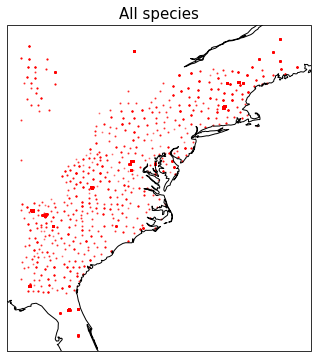

In [12]:
df_tallo_usae = df_tallo[(df_tallo['latitude'] >= 25) & (df_tallo['latitude'] <= 55) & 
                         (df_tallo['longitude'] >= -85) & (df_tallo['longitude'] <= -67)]


fig1, ((f1ax0)) = plt.subplots(nrows=1, ncols=1,  subplot_kw={'projection': ccrs.PlateCarree()},
                                                   figsize=(16,6))

f1ax0.scatter(df_tallo_usae.longitude, df_tallo_usae.latitude, color='red', s=1, marker='o',  alpha=0.4, transform=ccrs.PlateCarree())
f1ax0.coastlines()
f1ax0.set_title('All species', fontsize=15)

In [13]:
df_tallo_usae['PFT_tallo'].unique()

array(['broadleaf_extratrop', 'broadleaf_deciduous_extratrop',
       'needleleaf_extratrop', 'needleleaf_evergreen_extratrop'],
      dtype=object)

In [14]:
# Let's assume all broadleaf are deciduous and all needleleaf are evergreen
def condition(x) : 
    if x == 'broadleaf_extratrop':
        return 'broadleaf_deciduous_extratrop'
    elif x == 'needleleaf_extratrop': 
        return 'needleleaf_evergreen_extratrop'
    else : 
        return x
    
df_tallo_usae.loc[:,('PFT_tallo')] = df_tallo_usae.loc[:,('PFT_tallo')].apply(condition).values

print(df_tallo_usae['PFT_tallo'].unique())

['broadleaf_deciduous_extratrop' 'needleleaf_evergreen_extratrop']


/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


#### Fit height

[46.09820802  0.93277477 28.84758308]
[52.69707617  0.94855988 46.79252608]


Text(0.5, 0.01, 'DBH (cm)')

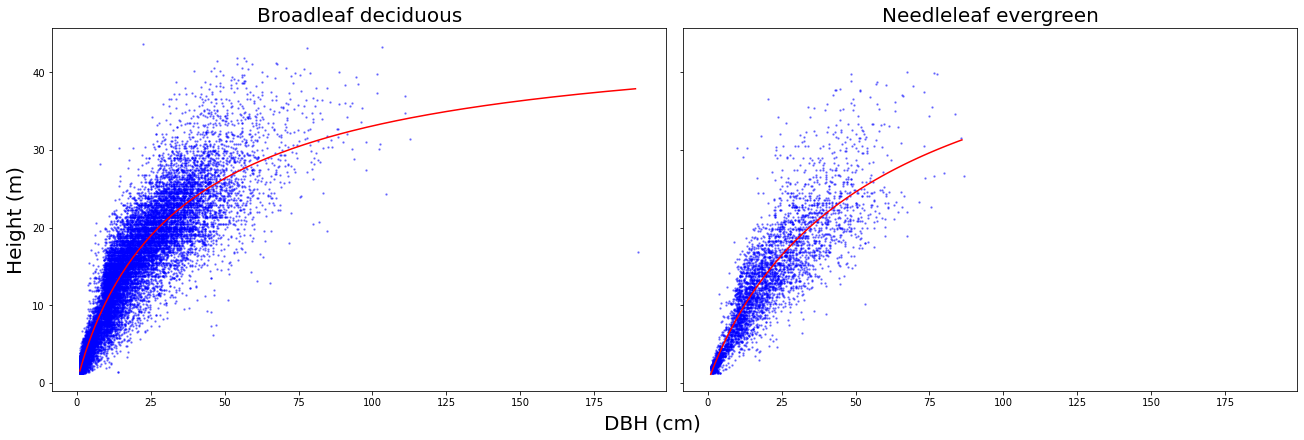

In [15]:
titles = ['Broadleaf deciduous', 'Needleleaf evergreen']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6), sharex=True, sharey=True, constrained_layout=True)
  
for i  in range(0,2): 
    if i == 0: 
        df =  df_tallo_usae[df_tallo_usae['PFT_tallo'] == 'broadleaf_deciduous_extratrop']
    elif i == 1:
        df =  df_tallo_usae[df_tallo_usae['PFT_tallo'] == 'needleleaf_evergreen_extratrop']
   

    df =  df.dropna(subset=['height', 'dbh'])
    # remove outliers
    df = df[df['height_outlier'] == 'N']
    dbh_df = np.arange(1,df['dbh'].max(),1)

    height_ps_df, height_cov_df = curve_fit(f=d2hmc, xdata=np.array(df['dbh']), ydata=np.array(df['height']),
                                               p0=initial_guess)
    
    print(height_ps_df)
    
    df_curve = [d2hmc(d, height_ps_df[0], height_ps_df[1], height_ps_df[2])  for  d  in dbh_df]


    axs[i].scatter(df.dbh, df.height, c='blue', s=2, alpha = 0.4)
    axs[i].plot(dbh_df, df_curve, color='red')
    axs[i].set_title(titles[i], fontsize=20)
    
fig.supylabel('Height (m)', fontsize=20)
fig.supxlabel('DBH (cm)', fontsize=20)


#### Fit crown areas 

[1.20542773]
[1.14074179]
[1.07790959]
[1.02839038]


Text(0.5, 0.01, 'DBH (cm)')

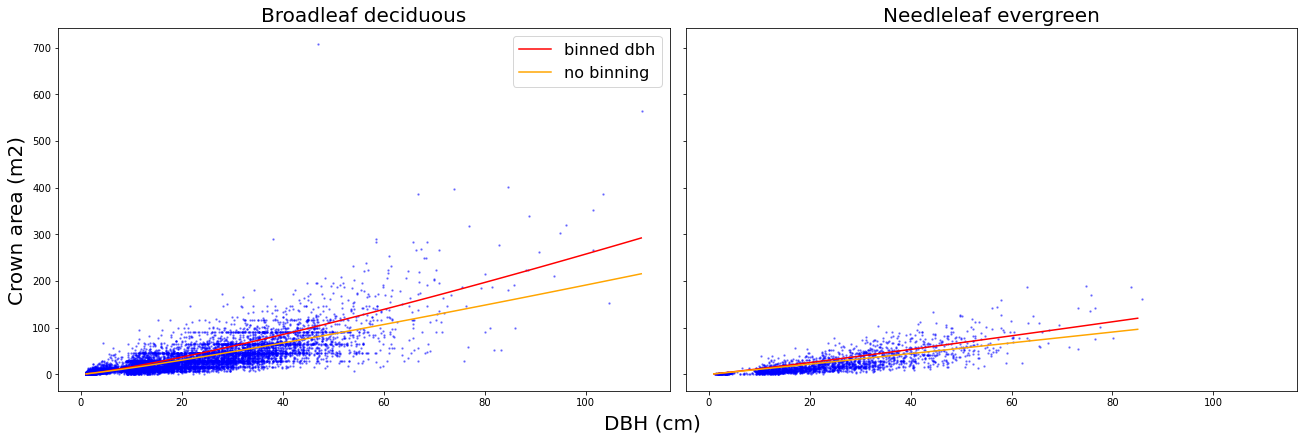

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6), sharex=True, sharey=True, constrained_layout=True)
  
for i  in range(0,2): 
    if i == 0: 
        df =  df_tallo_usae[df_tallo_usae['PFT_tallo'] == 'broadleaf_deciduous_extratrop']
    elif i == 1:
        df =  df_tallo_usae[df_tallo_usae['PFT_tallo'] == 'needleleaf_evergreen_extratrop']
   
    df =  df.dropna(subset=['crown_area', 'dbh'])
    # remove outliers
    df = df[df['crown_radius_outlier'] == 'N']
    dbh_df = np.arange(1,df['dbh'].max(),1)

    # now bin by dbh and  find quartiles 
    num_bins = 7
    bin_edges = np.linspace(df['dbh'].min(), df['dbh'].max(), num_bins + 1)
    df['dbh_bin'] = pd.cut(df['dbh'], bins=bin_edges)
    quantiles = [0.25, 0.5, 0.75]
    pseudo_ca = df.groupby('dbh_bin')['crown_area'].quantile(quantiles).unstack().reset_index()
    # Calculate the midpoints of the bins
    midpoints = (bin_edges[1:] + bin_edges[:-1]) / 2
    pseudo_ca['dbh_bin'] = midpoints
    df_new = pd.DataFrame(pseudo_ca)
    # Stack the columns into a single column, retaining 'ID' as the identifier
    stacked_df = pd.melt(df_new, id_vars=['dbh_bin'], var_name='Variable', value_name='Value')

    pseudo_ca_ps_df, pseudo_ca_cov_df = curve_fit(f=d2ca, xdata=np.array(stacked_df['dbh_bin']),
                                                   ydata=np.array(stacked_df['Value']), p0=1.3)
    
    print(pseudo_ca_ps_df)

    pseudo_df_curve = [d2ca(d, pseudo_ca_ps_df[0])  for  d  in dbh_df]

    axs[i].scatter(df.dbh, df.crown_area, c='blue', s=2, alpha = 0.4)
    axs[i].plot(dbh_df, pseudo_df_curve, color='red', label = 'binned dbh')
    axs[i].set_title(titles[i], fontsize=20)
    
    ca_ps_df, ca_cov_df = curve_fit(f=d2ca, xdata=np.array(df['dbh']), ydata=np.array(df['crown_area']),
                                               p0=1.3)
    
    print(ca_ps_df)
    
    df_curve = [d2ca(d, ca_ps_df[0])  for  d  in dbh_df]
    axs[i].plot(dbh_df, df_curve, color='orange', label = 'no binning')

axs[0].legend(fontsize=16)    
fig.supylabel('Crown area (m2)', fontsize=20)
fig.supxlabel('DBH (cm)', fontsize=20)


#### Wood density

In [17]:
# Subset BAAD data by east coast USA

Text(0.5, 1.0, 'All species')

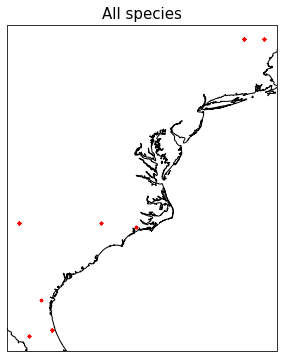

In [18]:
df_baad_usae = df_baad[(df_baad['latitude'] >= 25) & (df_baad['latitude'] <= 55) & 
                         (df_baad['longitude'] >= -85) & (df_baad['longitude'] <= -67)]


fig1, ((f1ax0)) = plt.subplots(nrows=1, ncols=1,  subplot_kw={'projection': ccrs.PlateCarree()},
                                                   figsize=(16,6))

f1ax0.scatter(df_baad_usae.longitude, df_baad_usae.latitude, color='red', s=5, marker='o',  alpha=0.4, transform=ccrs.PlateCarree())
f1ax0.coastlines()
f1ax0.set_title('All species', fontsize=15)

In [19]:
# Merge DataFrames based on matching values in 'x' and 's'
merged_df = df_baad_usae.merge(df_wd_mean, left_on='species', right_on='ScientificName', how='left')
merged_df['wd'] = merged_df['wood_dens'].fillna(merged_df['wd'])
merged_df = merged_df.drop(columns=['wood_dens'])
df_baad_usae = merged_df

In [20]:
print(df_baad_usae.head(3))

print(df_baad_usae['PFT_baad'].unique())

                         PFT_baad    family      species  latitude  longitude  \
0  needleleaf_evergreen_extratrop  Pinaceae  Pinus taeda    34.823    -77.303   
1  needleleaf_evergreen_extratrop  Pinaceae  Pinus taeda    34.823    -77.303   
2  needleleaf_evergreen_extratrop  Pinaceae  Pinus taeda    34.823    -77.303   

    dbh  height  crown_area       agb        wd     bleaf ScientificName  
0  5.23    4.37         NaN  5.452473  0.367205  1.694821    Pinus taeda  
1  5.31    4.22         NaN  4.368249  0.367205  1.343333    Pinus taeda  
2  1.70    2.64         NaN  0.817512  0.367205  0.246963    Pinus taeda  
['needleleaf_evergreen_extratrop' 'broadleaf_deciduous_extratrop']


In [21]:
df_baad_usae.groupby(['PFT_baad']).mean()

,latitude,longitude,dbh,height,crown_area,agb,wd,bleaf
PFT_baad,,,,,,,,
broadleaf_deciduous_extratrop,40.682203,-75.754237,17.915763,14.733263,NaN,363.901880,0.582007,5.483217
needleleaf_evergreen_extratrop,31.749347,-80.407036,7.020398,5.264422,2.009121,19.379993,0.371920,2.558915


#### AGB 

[0.08187483 1.02066147]


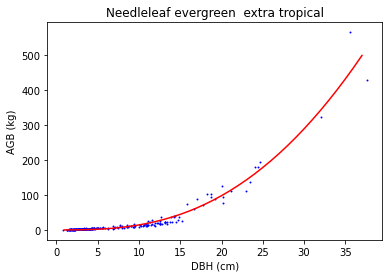

In [22]:
# Needleleaf evergreen extra tropical 
nleex = df_baad_usae[df_baad_usae.PFT_baad=='needleleaf_evergreen_extratrop']
nleex =  nleex.dropna(subset=['agb', 'dbh'])
dbh_nleex = np.arange(1,nleex['dbh'].max(),1)

initial_guess = [0.0673, 0.976]

def dh2bagw_nleex (d, p1, p2) :
    
    # set fixed parameters
    wd = 0.371920
    h1 = 52.69707617
    h2 = 0.94855988
    h3 = 46.79252608
    
    h = (h1 * d**h2) / (h3 + d*h2)
    
    agb = ( p1 * (wd * d**2 * h)**p2 ) / 2
    
    return agb


agb_ps_nleex, agb_cov_nleex = curve_fit(f=dh2bagw_nleex, xdata=np.array(nleex['dbh']), ydata=np.array(nleex['agb']),
                                           p0=initial_guess)

dbh_nleex = np.arange(1,nleex['dbh'].max(),1)

nleex_curve = [dh2bagw_nleex(d, agb_ps_nleex[0], agb_ps_nleex[1])  for  d  in dbh_nleex]

plt.scatter(nleex.dbh, nleex.agb, s=0.9, color='blue')
plt.plot(dbh_nleex, nleex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('AGB (kg)')
plt.title('Needleleaf evergreen  extra tropical')

print(agb_ps_nleex)

[0.12918309 0.981921  ]


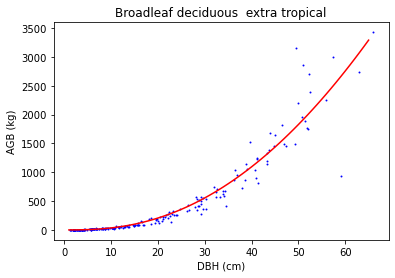

In [23]:
# Broadleaf deciduous extra tropical 
nleex = df_baad_usae[df_baad_usae.PFT_baad=='broadleaf_deciduous_extratrop']
nleex =  nleex.dropna(subset=['agb', 'dbh'])
dbh_nleex = np.arange(1,nleex['dbh'].max(),1)

initial_guess = [0.0673, 0.976]

def dh2bagw_nleex (d, p1, p2) :
    
    # set fixed parameters
    wd = 0.582007
    h1 = 46.09820802
    h2 = 0.93277477
    h3 = 28.84758308
    
    h = (h1 * d**h2) / (h3 + d*h2)
    
    agb = ( p1 * (wd * d**2 * h)**p2 ) / 2
    
    return agb


agb_ps_nleex, agb_cov_nleex = curve_fit(f=dh2bagw_nleex, xdata=np.array(nleex['dbh']), ydata=np.array(nleex['agb']),
                                           p0=initial_guess)

dbh_nleex = np.arange(1,nleex['dbh'].max(),1)

nleex_curve = [dh2bagw_nleex(d, agb_ps_nleex[0], agb_ps_nleex[1])  for  d  in dbh_nleex]

plt.scatter(nleex.dbh, nleex.agb, s=0.9, color='blue')
plt.plot(dbh_nleex, nleex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('AGB (kg)')
plt.title('Broadleaf deciduous  extra tropical')

print(agb_ps_nleex)

#  Mexico

####  Oaks  - none in Mexco

In [24]:
quercus = df_tallo[df_tallo['species'].str.contains('Quercus', case=False)]
print(quercus.head(3))
print(len(quercus))

                 species  latitude  longitude  dbh  height height_outlier  \
1813      Quercus kerrii    18.617    108.951  3.0     5.0              N   
1898  Quercus macrocalyx    18.683    108.876  3.0     4.5              N   
2020    Quercus auricoma    18.731    109.867  3.0     7.0              N   

      crown_radius_m crown_radius_outlier           PFT_tallo  crown_area  
1813             0.5                    N  broadleaf_tropical    0.785398  
1898             0.6                    N  broadleaf_tropical    1.130973  
2020             0.6                    N  broadleaf_tropical    1.130973  
69107


Text(0.5, 1.0, 'Quercus')

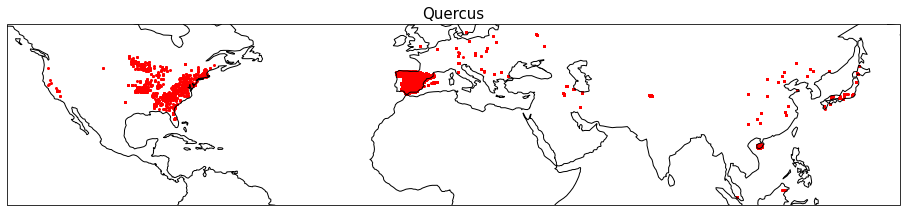

In [25]:
fig1, ((f1ax0)) = plt.subplots(nrows=1, ncols=1,  subplot_kw={'projection': ccrs.PlateCarree()},
                                                   figsize=(16,6))

f1ax0.scatter(quercus.longitude, quercus.latitude, color='red', s=4, marker='o', transform=ccrs.PlateCarree())
f1ax0.coastlines()
f1ax0.set_title('Quercus', fontsize=15)

(-120.0, -86.0)

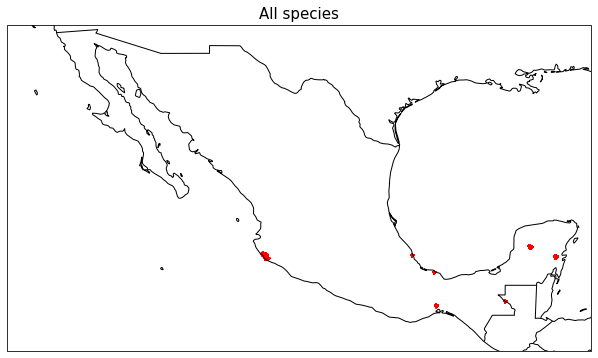

In [26]:
# Define the bounding box coordinates for Mexico
north_lat = 30.
south_lat = 14.
west_lon = -120.
east_lon = -86.

# Filter the DataFrame to include only coordinates within the bounding box
df_tallo_mx = df_tallo[
    (df_tallo['latitude'] >= south_lat) &
    (df_tallo['latitude'] <= north_lat) &
    (df_tallo['longitude'] >= west_lon) &
    (df_tallo['longitude'] <= east_lon)
]

fig1, ((f1ax0)) = plt.subplots(nrows=1, ncols=1,  subplot_kw={'projection': ccrs.PlateCarree()},
                                                   figsize=(16,6))

f1ax0.scatter(df_tallo_mx.longitude, df_tallo_mx.latitude, color='red', s=5, marker='o',  alpha=0.4, transform=ccrs.PlateCarree())
f1ax0.coastlines()
f1ax0.add_feature(cf.BORDERS)
f1ax0.set_title('All species', fontsize=15)
f1ax0.set_ylim(14, 33)
f1ax0.set_xlim(-120, -86) 

In [27]:
len(df_tallo_mx['species'].unique())

497

In [28]:
print(df_tallo_mx['PFT_tallo'].unique())

['broadleaf_tropical']


In [29]:
# Divide into needleleaf and broadleaf -  regardless of deciduous/evergreen and extratropical/tropical
def condition(x) : 
    if x == 'broadleaf_tropical':
        return 'broadleaf'
    elif x == 'needleleaf_evergreen_extratrop': 
        return 'needleleaf'
    elif x == 'needleleaf_extratrop':
        return 'needleleaf'
    elif x == 'broadleaf_extratrop': 
        return 'broadleaf'
    elif x == 'broadleaf_deciduous_extratrop': 
        return 'broadleaf'
    elif x == 'broadleaf_evergreen_extratrop': 
        return 'broadleaf'
    else : 
        return x
    
df_tallo_mx.loc[:,('PFT_tallo')] = df_tallo_mx.loc[:,('PFT_tallo')].apply(condition).values

print(df_tallo_mx['PFT_tallo'].unique())

['broadleaf']


/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


#### Height

[65.13455603  0.60662789 26.41808279]


Text(0.5, 0.01, 'DBH (cm)')

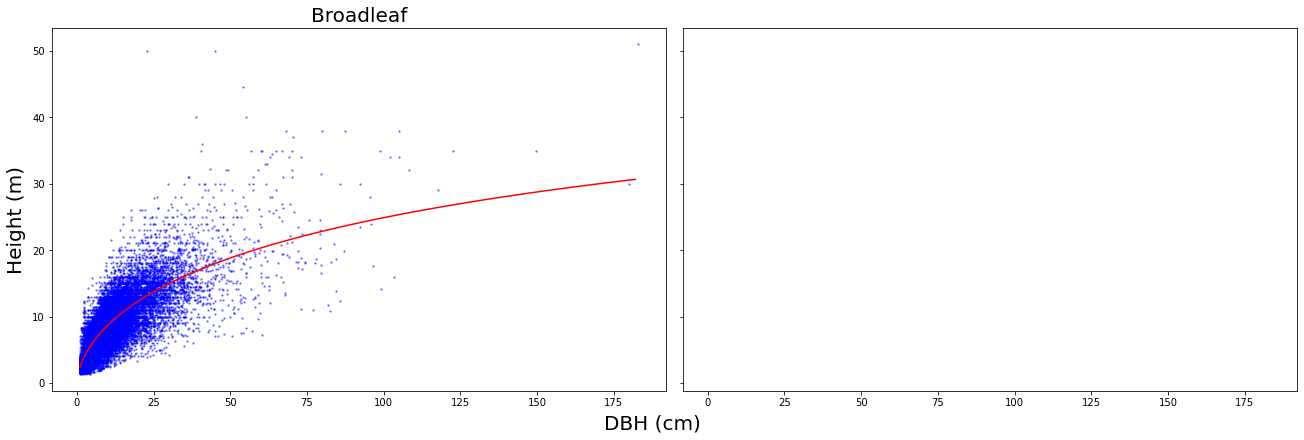

In [30]:
titles = ['Broadleaf']
initial_guess = [58.0, 0.73, 21.8]


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6), sharex=True, sharey=True, constrained_layout=True)
  
for i  in range(0,1): 
    if i == 0: 
        df =  df_tallo_mx[df_tallo_mx['PFT_tallo'] == 'broadleaf']
    elif i == 1:
        df =  df_tallo_mx[df_tallo_mx['PFT_tallo'] == 'needleleaf']
   

    df =  df.dropna(subset=['height', 'dbh'])
    # remove outliers
    df = df[df['height_outlier'] == 'N']
    dbh_df = np.arange(1,df['dbh'].max(),1)

    height_ps_df, height_cov_df = curve_fit(f=d2hmc, xdata=np.array(df['dbh']), ydata=np.array(df['height']),
                                               p0=initial_guess)
    
    print(height_ps_df)
    
    df_curve = [d2hmc(d, height_ps_df[0], height_ps_df[1], height_ps_df[2])  for  d  in dbh_df]


    axs[i].scatter(df.dbh, df.height, c='blue', s=2, alpha = 0.4)
    axs[i].plot(dbh_df, df_curve, color='red')
    axs[i].set_title(titles[i], fontsize=20)
    
fig.supylabel('Height (m)', fontsize=20)
fig.supxlabel('DBH (cm)', fontsize=20)


#### Crown area

[1.33140028]
[1.09259946]


Text(0.5, 0.01, 'DBH (cm)')

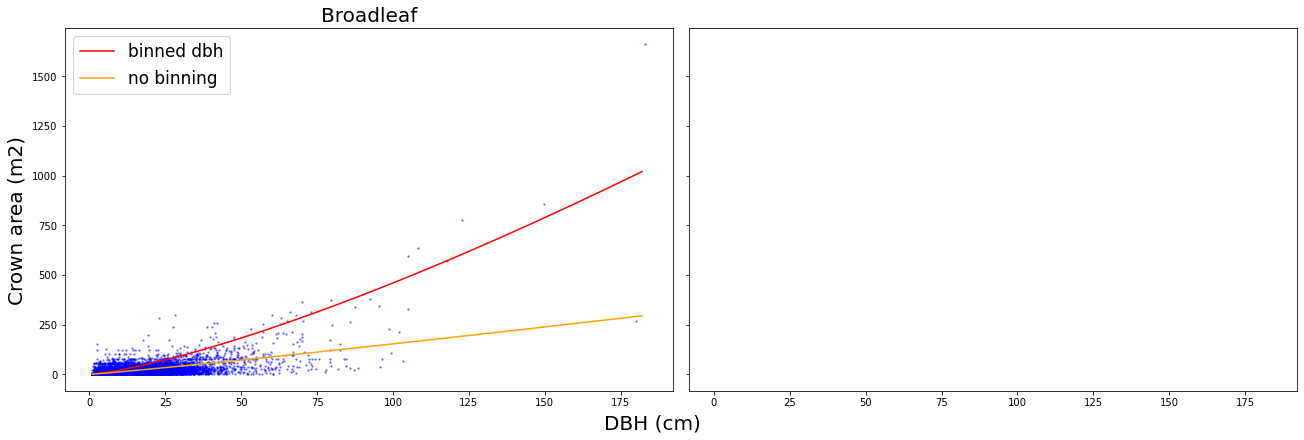

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6), sharex=True, sharey=True, constrained_layout=True)
  
for i  in range(0,1): 
    if i == 0: 
        df =  df_tallo_mx[df_tallo_mx['PFT_tallo'] == 'broadleaf']
    elif i == 1:
        df =  df_tallo_mx[df_tallo_mx['PFT_tallo'] == 'needleleaf']
   

    df =  df.dropna(subset=['crown_area', 'dbh'])
    # remove outliers
    df = df[df['crown_radius_outlier'] == 'N']
    dbh_df = np.arange(1,df['dbh'].max(),1)

    # now bin by dbh and  find quartiles 
    num_bins = 7
    bin_edges = np.linspace(df['dbh'].min(), df['dbh'].max(), num_bins + 1)
    df['dbh_bin'] = pd.cut(df['dbh'], bins=bin_edges)
    quantiles = [0.25, 0.5, 0.75]
    pseudo_ca = df.groupby('dbh_bin')['crown_area'].quantile(quantiles).unstack().reset_index()
    # Calculate the midpoints of the bins
    midpoints = (bin_edges[1:] + bin_edges[:-1]) / 2
    pseudo_ca['dbh_bin'] = midpoints
    df_new = pd.DataFrame(pseudo_ca)
    # Stack the columns into a single column, retaining 'ID' as the identifier
    stacked_df = pd.melt(df_new, id_vars=['dbh_bin'], var_name='Variable', value_name='Value')

    pseudo_ca_ps_df, pseudo_ca_cov_df = curve_fit(f=d2ca, xdata=np.array(stacked_df['dbh_bin']),
                                                   ydata=np.array(stacked_df['Value']), p0=1.3)
    
    print(pseudo_ca_ps_df)

    pseudo_df_curve = [d2ca(d, pseudo_ca_ps_df[0])  for  d  in dbh_df]

    axs[i].scatter(df.dbh, df.crown_area, c='blue', s=2, alpha = 0.4)
    axs[i].plot(dbh_df, pseudo_df_curve, color='red', label = 'binned dbh')
    axs[i].set_title(titles[i], fontsize=20)
    
    ca_ps_df, ca_cov_df = curve_fit(f=d2ca, xdata=np.array(df['dbh']), ydata=np.array(df['crown_area']),
                                               p0=1.3)
    
    print(ca_ps_df)
    
    df_curve = [d2ca(d, ca_ps_df[0])  for  d  in dbh_df]
    axs[i].plot(dbh_df, df_curve, color='orange', label = 'no binning')
    
axs[i].legend(fontsize=17)    
fig.supylabel('Crown area (m2)', fontsize=20)
fig.supxlabel('DBH (cm)', fontsize=20)


#### AGB - use BAAD data

In [32]:
# Define the bounding box coordinates for Mexico
north_lat = 30.
south_lat = 14.
west_lon = -120.
east_lon = -86.

# Filter the DataFrame to include only coordinates within the bounding box
df_baad_mx = df_baad[
    (df_baad['latitude'] >= south_lat) &
    (df_baad['latitude'] <= north_lat) &
    (df_baad['longitude'] >= west_lon) &
    (df_baad['longitude'] <= east_lon)
]

print(df_baad_mx.head(3))

print(df_baad_mx.species.unique())

Empty DataFrame
Columns: [PFT_baad, family, species, latitude, longitude, dbh, height, crown_area, agb, wd, bleaf]
Index: []
[]


#### No species - from Mexican sites in BAAD